<a href="https://colab.research.google.com/github/ozakiryota/kaggle/blob/main/titanic/titanic_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downlad and check datasets

Activate Kaggle API

In [62]:
from google.colab import files
import os

jason_path = "/root/.kaggle/kaggle.json"

if not os.path.exists(jason_path):
    uploaded = files.upload()

    for fn in uploaded.keys():
        print("User uploaded file '{name}' with length {length} bytes".format(
            name=fn, length=len(uploaded[fn])))

    # Then move kaggle.json into the folder where the API expects to find it.
    !mkdir -p /root/.kaggle/ && mv kaggle.json /root/.kaggle/ && chmod 600 /root/.kaggle/kaggle.json

else:
    print(jason_path, "is already exists.")

/root/.kaggle/kaggle.json is already exists.


Download the datasets

In [63]:
!pip install kaggle
!kaggle competitions download -c titanic

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


Check the datasets

In [64]:
import pandas as pd

df = pd.read_csv("/content/train.csv")
# df = pd.read_csv("/content/test.csv")
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Fuctions and class

In [65]:
import pandas as pd

def makeDataList(csv_path):
    datalist = pd.read_csv(csv_path)
    datalist = datalist.drop(["Name", "Ticket", "Cabin"], axis=1)
    # datalist["Sex"] = datalist["Sex"].replace("male", 0)
    # datalist["Sex"] = datalist["Sex"].replace("female", 1)
    # datalist["Embarked"] = datalist["Embarked"].replace("C", 0)
    # datalist["Embarked"] = datalist["Embarked"].replace("Q", 1)
    # datalist["Embarked"] = datalist["Embarked"].replace("S", 2)
    datalist = pd.get_dummies(datalist)
    datalist = datalist.fillna(-1)
    return datalist

In [66]:
## TEST
datalist = makeDataList("/content/train.csv")
print("datalist.values[0] =", datalist.values[0])
print(datalist)

datalist.values[0] = [ 1.    0.    3.   22.    1.    0.    7.25  0.    1.    0.    0.    1.  ]
     PassengerId  Survived  Pclass  ...  Embarked_C  Embarked_Q  Embarked_S
0              1         0       3  ...           0           0           1
1              2         1       1  ...           1           0           0
2              3         1       3  ...           0           0           1
3              4         1       1  ...           0           0           1
4              5         0       3  ...           0           0           1
..           ...       ...     ...  ...         ...         ...         ...
886          887         0       2  ...           0           0           1
887          888         1       1  ...           0           0           1
888          889         0       3  ...           0           0           1
889          890         1       1  ...           1           0           0
890          891         0       3  ...           0           1      

In [67]:
## TEST
from sklearn.model_selection import train_test_split

train_datalist, val_datalist = train_test_split(datalist, test_size=0.1, random_state=1234, shuffle=True)
print(train_datalist)
print(val_datalist)

     PassengerId  Survived  Pclass  ...  Embarked_C  Embarked_Q  Embarked_S
267          268         1       3  ...           0           0           1
635          636         1       2  ...           0           0           1
473          474         1       2  ...           1           0           0
207          208         1       3  ...           1           0           0
290          291         1       1  ...           0           0           1
..           ...       ...     ...  ...         ...         ...         ...
204          205         1       3  ...           0           0           1
53            54         1       2  ...           0           0           1
294          295         0       3  ...           0           0           1
723          724         0       2  ...           0           0           1
815          816         0       1  ...           0           0           1

[801 rows x 12 columns]
     PassengerId  Survived  Pclass  ...  Embarked_C  Embarked_Q

In [68]:
import numpy as np

import torch.utils.data as data

class DatasetMaker(data.Dataset):
    def __init__(self, datalist):
        self.input_datalist = datalist.drop(["PassengerId", "Survived"], axis=1).values.astype(np.float32)
        self.label_datalist = datalist["Survived"].values.astype(np.long)

    def __len__(self):
        return len(self.input_datalist)

    def __getitem__(self, index):
        inputs = self.input_datalist[index]
        labels = self.label_datalist[index]
        return inputs, labels

In [69]:
## TEST
dataset = DatasetMaker(datalist)
print("dataset.__len__() =", dataset.__len__())
print("dataset.__getitem__(index=0)[0] =", dataset.__getitem__(index=0)[0])
print("dataset.__getitem__(index=0)[1] =", dataset.__getitem__(index=0)[1])

dataset.__len__() = 891
dataset.__getitem__(index=0)[0] = [ 3.   22.    1.    0.    7.25  0.    1.    0.    0.    1.  ]
dataset.__getitem__(index=0)[1] = 0


In [70]:
## TEST
import torch

batch_size = 10
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
batch_itr = iter(dataloader)
inputs, labels = next(batch_itr)

print("inputs =\n", inputs)
print("inputs.size() =", inputs.size())
print("labels =", labels)
print("labels.size() =", labels.size())

inputs =
 tensor([[  3.0000,  -1.0000,   0.0000,   0.0000,   8.0500,   0.0000,   1.0000,
           0.0000,   0.0000,   1.0000],
        [  1.0000,  48.0000,   1.0000,   0.0000,  39.6000,   1.0000,   0.0000,
           1.0000,   0.0000,   0.0000],
        [  1.0000,  27.0000,   1.0000,   0.0000,  53.1000,   0.0000,   1.0000,
           0.0000,   0.0000,   1.0000],
        [  1.0000,  19.0000,   3.0000,   2.0000, 263.0000,   0.0000,   1.0000,
           0.0000,   0.0000,   1.0000],
        [  3.0000,  26.0000,   0.0000,   0.0000,  56.4958,   0.0000,   1.0000,
           0.0000,   0.0000,   1.0000],
        [  3.0000,  19.0000,   0.0000,   0.0000,   8.0500,   0.0000,   1.0000,
           0.0000,   0.0000,   1.0000],
        [  1.0000,  23.0000,   1.0000,   0.0000, 113.2750,   1.0000,   0.0000,
           1.0000,   0.0000,   0.0000],
        [  1.0000,   4.0000,   0.0000,   2.0000,  81.8583,   0.0000,   1.0000,
           0.0000,   0.0000,   1.0000],
        [  1.0000,  29.0000,   0.0000,

In [71]:
from torch import nn

class Network(nn.Module):
    def __init__(self, dim_inputs, dim_mid, dim_outputs, dropout_rate):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(dim_inputs, dim_mid),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(dim_mid, dim_mid),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(dim_mid, dim_mid),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(dim_mid, dim_outputs)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [72]:
## TEST
net = Network(len(dataset.__getitem__(index=0)[0]), 64, 2, dropout_rate=0.1)
outputs = net(inputs)
print("outputs = \n", outputs)
print("outputs.size() =", outputs.size())

outputs = 
 tensor([[-0.0613,  0.0311],
        [-0.3169, -1.5430],
        [ 0.4369, -1.6075],
        [-2.4580, -4.6016],
        [-0.1449, -0.0452],
        [-0.2018, -0.5471],
        [-1.3775,  1.3365],
        [-1.3170, -0.2204],
        [-4.4757,  0.3966],
        [ 0.0284,  0.0554]], grad_fn=<AddmmBackward0>)
outputs.size() = torch.Size([10, 2])


# Training

self.device = cpu
Network(
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
)
----------
Epoch 1/200
train Loss: 0.6814
val Loss: 0.6289
----------
Epoch 20/200
train Loss: 0.5561
val Loss: 0.5186
----------
Epoch 40/200
train Loss: 0.5156
val Loss: 0.4621
----------
Epoch 60/200
train Loss: 0.4839
val Loss: 0.4404
----------
Epoch 80/200
train Loss: 0.4614
val Loss: 0.4102
----------
Epoch 100/200
train Loss: 0.4182
val Loss: 0.4073
----------
Epoch 120/200
train Loss: 0.4071
val Loss: 0.4049
----------
Epoch 140/200
train Loss: 0.4035
val Loss: 0.4037
----------
Epoch 160/200
train Loss: 0.3913
val Loss: 0.4041


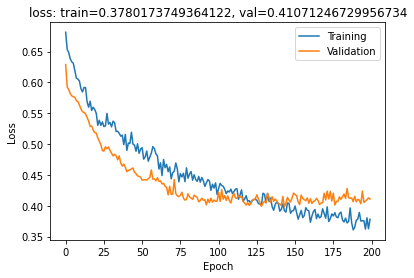

In [73]:
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim

class Trainer:
    def __init__(self, csv_path, num_epochs, batch_size, lr, save_weights_path):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("self.device =", self.device)
        
        datalist = makeDataList(csv_path)
        train_datalist, val_datalist = train_test_split(datalist, test_size=0.1, random_state=1234, shuffle=True)
        train_dataset = DatasetMaker(train_datalist)
        val_dataset = DatasetMaker(val_datalist)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
        
        self.num_epochs = num_epochs
        self.dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
        self.net = Network(len(train_dataset.__getitem__(index=0)[0]), 64, 2, dropout_rate=0.1)
        self.net.to(self.device)
        print(net)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)

    def train(self):
        ## time
        start_clock = time.time()
        ## record
        record_train_loss = []
        record_val_loss = []
        record_loss_dict = {"train": [], "val": []}
        min_loss_epoch = 0.0
        ## loop
        for epoch in range(self.num_epochs):
            if epoch == 0 or not (epoch+1) % (num_epochs // 10):
                print("----------")
                print("Epoch {}/{}".format(epoch+1, self.num_epochs))
            ## phase
            for phase in ["train", "val"]:
                ## setting
                if phase == "train":
                    self.net.train()
                else:
                    self.net.eval()
                ## buffer
                loss_epoch = 0.0
                num_inputs_epoch = 0
                ## mini-batch
                for inputs, labels in self.dataloaders_dict[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    ## reset gradient
                    self.optimizer.zero_grad()
                    ## switch computing gradient
                    with torch.set_grad_enabled(phase == "train"):
                        ## forward
                        outputs = self.net(inputs)
                        loss = self.criterion(outputs, labels)
                        ## backward
                        if phase == "train":
                            loss.backward()
                            self.optimizer.step()
                    ## add
                    loss_epoch += loss.item() * inputs.size(0)
                    num_inputs_epoch += inputs.size(0)
                ## average loss
                loss_epoch = loss_epoch / len(self.dataloaders_dict[phase].dataset)
                record_loss_dict[phase].append(loss_epoch)
                if epoch == 0 or not (epoch+1) % (num_epochs // 10):
                    print("{} Loss: {:.4f}".format(phase, loss_epoch))
            ## save
            if epoch == 0 or record_loss_dict["val"][-1] < min_loss_epoch:
                min_loss_epoch = record_loss_dict["val"][-1]
                torch.save(self.net.state_dict(), save_weights_path)
        ## time
        mins = (time.time() - start_clock) // 60
        secs = (time.time() - start_clock) % 60
        print ("training time: ", mins, " [min] ", secs, " [sec]")
        ## graph
        self.showGraph(record_loss_dict)

    def showGraph(self, record_loss_dict):
        graph = plt.figure()
        plt.plot(range(len(record_loss_dict["train"])), record_loss_dict["train"], label="Training")
        plt.plot(range(len(record_loss_dict["val"])), record_loss_dict["val"], label="Validation")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("loss: train=" + str(record_loss_dict["train"][-1]) + ", val=" + str(record_loss_dict["val"][-1]))
        plt.show()


csv_path = "/content/train.csv"
num_epochs = 200
batch_size = 80
lr = 0.001
save_weights_path = "/content/weights.pth"

trainer = Trainer(csv_path, num_epochs, batch_size, lr, save_weights_path)
trainer.train()

# Evaluation

In [74]:
import time
import pandas as pd

import torch

class Evaluator:
    def __init__(self, csv_path, weights_path, save_csv_path):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("self.device = ", self.device)

        self.save_csv_path = save_csv_path
        self.datalist = makeDataList(csv_path)
        self.net = Network(self.datalist.drop("PassengerId", axis=1).values.shape[1], 64, 2, dropout_rate=0.1)
        self.net.to(self.device)
        if torch.cuda.is_available():
            loaded_weights = torch.load(weights_path)
            print("Weights have been loaded [GPU -> GPU]:", weights_path)
        else:
            loaded_weights = torch.load(weights_path, map_location={"cuda:0": "cpu"})
            print("Weights have been loaded [GPU -> CPU]:", weights_path)
        self.net.load_state_dict(loaded_weights)
        print(self.net)

    def evaluate(self):
        ## time
        start_clock = time.time()
        ## setting
        self.net.eval()
        ## ndarray -> tensor
        inputs = torch.from_numpy(self.datalist.drop("PassengerId", axis=1).values.astype(np.float32))
        inputs = inputs.to(self.device)
        ## forward
        with torch.no_grad():
            outputs = self.net(inputs)
            outputs = torch.max(outputs, dim=1).indices
        ## save
        self.writeCSV(outputs)
        ## time
        mins = (time.time() - start_clock) // 60
        secs = (time.time() - start_clock) % 60
        print ("evaluation time: ", mins, " [min] ", secs, " [sec]")

    def writeCSV(self, outputs):
        result_df = pd.DataFrame({"PassengerId": self.datalist["PassengerId"].values, "Survived": outputs.cpu().detach().numpy()})
        result_df.to_csv(self.save_csv_path, index=False)
        print(result_df)


csv_path = "/content/test.csv"
weights_path = "/content/weights.pth"
save_csv_path = "/content/submission.csv"

evaluator = Evaluator(csv_path, weights_path, save_csv_path)
evaluator.evaluate()

self.device =  cpu
Weights have been loaded [GPU -> CPU]: /content/weights.pth
Network(
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
)
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
evaluation time:  0.0  [min]  0.02380967140197754  [sec]


# Submission

In [75]:
import sys

print("Submit the file? (y/n)")
ans = input()
while ans != "y" and ans != "n":
    print("Type 'y' or 'n'")
    ans = input()
if ans == "y":
    !kaggle competitions submit -c titanic -f $save_csv_path -m "titanic_dnn.ipynb"

Submit the file? (y/n)
n
